In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor 
import numpy as np
import matplotlib.pyplot as plt
features_array = np.loadtxt('features.txt')
targets_array = np.loadtxt('targets.txt')
print(features_array.shape)

gaussian = GaussianProcessRegressor()
#arg 1 is your data, arg 2 is the targets

gaussian_model = gaussian.fit(features_array, targets_array)
gaussian_model
# gaussian_model.kernel_

(150, 10)


GaussianProcessRegressor()

In [2]:
lb = [-0.01, -0.05, -0.01, -0.05, -0.01, -0.05, -0.01, -0.05, -0.01, -0.05]
ub = [0.287397, 0.014, 0.287397, 0.014, 0.287397, 0.014, 0.287397, 0.014, 0.287397, 0.014]

# feature_1 = np.linspace(lb[0], ub[0], num=100)
# print(feature_1)

# points_num = 500

# ac_array = np.empty((points_num, 10))

# for i in range (0,10):
#     points = np.linspace(lb[i], ub[i], num=points_num)
#     for j in range(0,points_num):
#         ac_array[j,i] =points[j] 

decision_vectors = np.loadtxt('decision_vectors.txt')
decision_vectors.shape


(100000, 10)

In [3]:
u_pred, u_std = gaussian_model.predict(decision_vectors, return_std=True)
print(u_pred)

[8.43787651 9.22006103 7.71618866 ... 9.23428031 9.35039716 8.26108477]


In [4]:
features_array[2:5].shape

(3, 10)

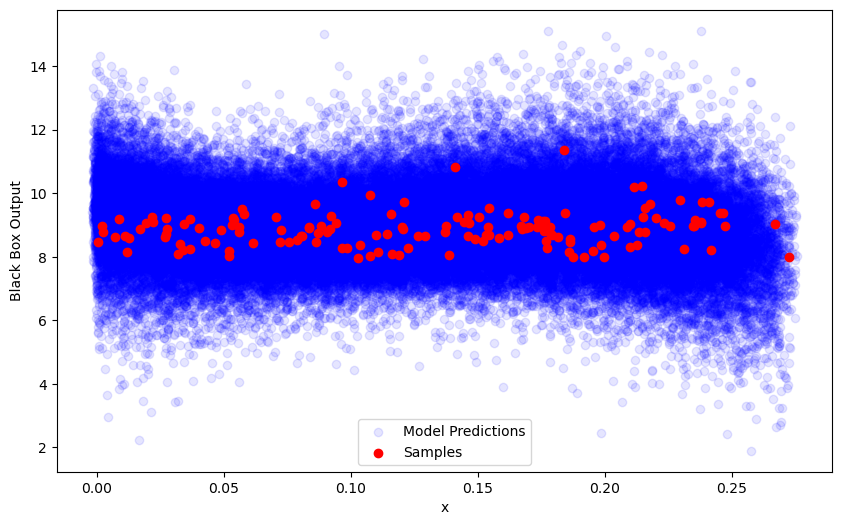

In [5]:
# Plot 
# for i in range(0,10):
plt.figure(figsize=(10, 6))
# plt.plot(x_range, black_box_function(x_range), label='Black Box Function')
plt.scatter(decision_vectors[:,0], u_pred, color='blue', label='Model Predictions', alpha = 0.1)
plt.scatter(features_array[:,0], targets_array, color='red', label='Samples')

# plt.fill_between(decision_vectors[:,0], u_pred - 2*u_std, u_pred + 2*u_std, color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('Black Box Output')
# plt.title('Black Box Function with Gaussian Process Surrogate Model')
plt.legend()
plt.show()

In [6]:
max_index = np.argmax(u_pred)
print(max_index)

print(u_pred[58951])
print(decision_vectors[58951])

58951
15.109030892029956
[ 2.37812026e-01 -9.29188325e-03  9.21561896e-05 -3.24454006e-03
  5.03108202e-02 -4.98896329e-02  1.04059115e-02 -2.49194174e-02
  1.82325942e-01 -4.82310034e-02]


In [15]:
test_data = np.empty((1,10))
test_data[0] =  [0.14536788, -0.01074501,  0.09885646, -0.00420489,  0.07697168,  0.0017507, 0.1878299,  -0.04972652,  0.18111835, -0.00705584]
print(test_data.shape)
# test_data = np.reshape(test_data, (-1,1))
# prediction = gaussian_model.predict(test_data)


# get the stdev on the predictions
pred, stdev = gaussian_model.predict(decision_vectors, return_std=True)

print(stdev)


(1, 10)
[0.00058305 0.00070838 0.0007662  ... 0.00046807 0.00062948 0.00071069]


In [24]:
def acquisition(model, X, n_samples, mode: str = 'ei'):
    # return the top n_samples from X that have the highest expected improvement

    # get the mean and stdev from the model
    pred, stdev = model.predict(X, return_std=True)

    # calculate the expected improvement
    if mode == 'ei':
        # calculate the expected improvement
        best = np.max(pred)
        score = stdev * (pred - best)
    else:
        raise NotImplementedError

    # get the top n_samples with the highest expected improvement
    top_n_samples = np.argsort(score)[-n_samples:]

    return top_n_samples

In [27]:
new_samples = acquisition(gaussian_model, decision_vectors, 10, mode='ei')

In [28]:
new_samples

array([84455, 94558, 65230, 92568, 96443, 82354, 25013, 85245, 62690,
       58951])

In [29]:
print(decision_vectors[84455])

[ 0.15482812 -0.00928034  0.05804449 -0.0048971   0.11719631 -0.0215742
  0.12517529 -0.02440211  0.05448439 -0.02141562]


In [2]:
import multiprocessing as mp
from multiprocessing import Pool

print(mp.cpu_count())

8


In [1]:
# running parallel processes

import multiprocessing
from multiprocessing import Pool
import subprocess
from typing import Dict
import Exeter_CFD_Problems as TestSuite
import shutil
import tempfile
import os

def postprocess_result(settings):
    os.mkdir(os.path.join(settings["case_dir"], '/postProcessing/sampleDict/0'))
    os.mkdir(os.path.join(settings["case_dir"], '/system'))


    shutil.copy('/data/run/week_1_testing/PitzDailyOptimiser/sampleDict', settings["case_dir"] + '/system/sampleDict')


    subprocess.run(["postProcess -func sampleDict"], shell=True, cwd=settings["case_dir"])
    

    # os.system("cp sampleDict Exeter_CFD_Problems/data/PitzDaily/case_single/system/")
    # os.system("cd Exeter_CFD_Problems/data/PitzDaily/case_single/; )")

    outlet_pressure = np.loadtxt(os.path.join(settings["case_dir"], 'postProcessing/sampleDict/0/outlet_p.xy'), dtype=float,usecols = 1)
    inlet_pressure = np.loadtxt(os.path.join(settings["case_dir"], 'postProcessing/sampleDict/0/inlet_p.xy'), dtype=float,usecols = 1)

    try:
        outlet_pressure_avg = np.average(outlet_pressure) 
        inlet_pressure_avg = np.average(inlet_pressure)
        delta_p = abs(outlet_pressure_avg - inlet_pressure_avg)
        print('outlet_p =', outlet_pressure_avg, 'inlet_p =', inlet_pressure_avg, 'delta_p =', delta_p)

    except ValueError:
        max_xvelocity = np.nan

    return delta_p

# function to run the openFoam calculation
def run_openfoam_calculation(args) -> float:

    # unpack the arguments
    settings, decision_vector = args
    # run the openfoam calculation
    # return the output from the black box function
    prob = TestSuite.PitzDaily(settings)
    result = prob.evaluate(decision_vector)

    output = postprocess_result(settings)

    return output

AttributeError: 'tuple' object has no attribute 'find'

In [ ]:
n_iters = 100

n_procs = multiprocessing.cpu_count()

# load your initial samples
features_array = np.loadtxt('features.txt')
targets_array = np.loadtxt('targets.txt')


def initialise_settings_and_run_dir():
     # run the openfoam calculation on the new samples
    # define the base settings
    settings = {}
    settings['source_case'] = 'Exeter_CFD_Problems/data/PitzDaily/case_fine/' # source directory
    settings['case_path'] = 'Exeter_CFD_Problems/data/PitzDaily/case_single/' # case path where CFD simulations will run
    settings['boundary_files'] = ['Exeter_CFD_Problems/data/PitzDaily/boundary.csv']
    settings['fixed_points_files'] = ['Exeter_CFD_Problems/data/PitzDaily/fixed.csv']
    settings['n_control'] = [1] # you should be able to use any 

    # create a tmpdir to run the job in for each sample
    with tempfile.TemporaryDirectory() as tmpdir:
        # copy the contents of case_path to the tmpdir
        shutil.copytree(settings['case_path'], tmpdir)
        # update the case_path to the tmpdir
        settings['case_path'] = tmpdir

    return settings

for _ in range(n_iters):

    # fit initial model
    model = GaussianProcessRegressor()
    model.fit(features_array, targets_array)

    # query the model with the acquisition strategy
    new_samples = acquisition(model, decision_vectors, 10, mode='ei')


    settings = [initialise_settings_and_run_dir() for _ in range(n_procs)]

    args = [(settings[i], new_samples[i]) for i in range(n_procs)]



    with Pool(n_procs) as p:
        results = p.map(run_openfoam_calculation, args)

    # add the new samples to the training data
    features_array = np.vstack((features_array, new_samples)) #will this add the right thing? ie the 10 parameters, not just an index?
    targets_array = np.vstack((targets_array, results))





In [18]:
# from skopt import acquisition as ac

# ac = ac.gaussian_ei(decision_vectors, gaussian_model)
# print(ac)
np.argmax# (ac)

[0. 0. 0. ... 0. 0. 0.]


0

In [17]:
-0.0206,0
-0.0206,0.0254
0.206,0.0254
0.290,0.0166
0.290,-0.0166
0.206,-0.0254
0,-0.0254
0,-0.005
0,0
-0.0206,0

(-0.0206, 0)

In [9]:
for i in range(0,10):
    print(np.min(features_array[:,i]), np.max(features_array[:,i]))

0.00025904626270740853 0.27249453836276216
-0.048968936846363074 0.01219550595878656
-0.00027112301245183976 0.27019473441022746
-0.049002996149073524 0.012469339014471698
-0.0001075944160812952 0.2693276170663948
-0.04999962211734102 0.012544049036251781
-6.149298431965856e-05 0.2604697440551026
-0.049717051725724486 0.012225283716677048
-0.0004580045422725408 0.2633697180113689
-0.04980925117186768 0.012123149661578063


In [43]:
lb = [-0.01, -0.05, -0.01, -0.05, -0.01, -0.05, -0.01, -0.05, -0.01, -0.05]
ub = [0.287397, 0.014, 0.287397, 0.014, 0.287397, 0.014, 0.287397, 0.014, 0.287397, 0.014]

# feature_1 = np.linspace(lb[0], ub[0], num=100)
# print(feature_1)

points_num = 200

ac_array = np.empty((points_num, 10))

for i in range (0,10):
    points = np.linspace(lb[i], ub[i], num=points_num)
    for j in range(0,points_num):
        ac_array[j,i] =points[j] 

print(ac_array[40])


[ 0.04977829 -0.03713568  0.04977829 -0.03713568  0.04977829 -0.03713568
  0.04977829 -0.03713568  0.04977829 -0.03713568]


In [36]:
ac.gaussian_ei(ac_array, gaussian_model)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [170]:
features_copy = features_array
z = features_array[4,:]
# print(z)
features_copy = np.append(features_copy,z[None,:],axis=0)

print(features_copy)

# targets_copy = np.append(targets_array, 5)
# print(targets_copy)

deleted_array = np.delete(features_copy, [150])
print(deleted_array.shape)

[[ 0.15841371 -0.00725896  0.21449006 ... -0.02464014  0.18014651
  -0.00722875]
 [ 0.14894017  0.01219551  0.05684196 ... -0.03600738  0.07576668
  -0.00519651]
 [ 0.17498481 -0.03636932  0.17498416 ... -0.01168306  0.0978351
  -0.03978284]
 ...
 [ 0.00880844 -0.04090335 -0.00027112 ... -0.01048095  0.22123587
   0.00287421]
 [ 0.18640701 -0.03400696  0.22797276 ... -0.02846168  0.02269628
  -0.00566654]
 [ 0.01191753 -0.03651854  0.02142986 ... -0.0398416   0.08422912
  -0.01488477]]
(1509,)


In [ ]:
import multiprocessing
from multiprocessing import Pool
import subprocess
from typing import Dict
import Exeter_CFD_Problems as TestSuite
import shutil
import tempfile
import os

def postprocess_result(settings):
    os.mkdir(os.path.join(settings["case_dir"], '/postProcessing/sampleDict/0'))
    os.mkdir(os.path.join(settings["case_dir"], '/system'))


    shutil.copy('/data/run/week_1_testing/PitzDailyOptimiser/sampleDict', settings["case_dir"] + '/system/sampleDict')


    subprocess.run(["postProcess -func sampleDict"], shell=True, cwd=settings["case_dir"])
    

    # os.system("cp sampleDict Exeter_CFD_Problems/data/PitzDaily/case_single/system/")
    # os.system("cd Exeter_CFD_Problems/data/PitzDaily/case_single/; )")

    outlet_pressure = np.loadtxt(os.path.join(settings["case_dir"], 'postProcessing/sampleDict/0/outlet_p.xy'), dtype=float,usecols = 1)
    inlet_pressure = np.loadtxt(os.path.join(settings["case_dir"], 'postProcessing/sampleDict/0/inlet_p.xy'), dtype=float,usecols = 1)

    try:
        outlet_pressure_avg = np.average(outlet_pressure) 
        inlet_pressure_avg = np.average(inlet_pressure)
        delta_p = abs(outlet_pressure_avg - inlet_pressure_avg)
        print('outlet_p =', outlet_pressure_avg, 'inlet_p =', inlet_pressure_avg, 'delta_p =', delta_p)

    except ValueError:
        print('value error')
        delta_p = np.nan

    return delta_p

def initialise_settings_and_run_dir():
     # run the openfoam calculation on the new samples
    # define the base settings
    settings = {}
    settings['source_case'] = 'Exeter_CFD_Problems/data/PitzDaily/case_fine/' # source directory
    settings['case_path'] = 'Exeter_CFD_Problems/data/PitzDaily/case_single/' # case path where CFD simulations will run
    settings['boundary_files'] = ['Exeter_CFD_Problems/data/PitzDaily/boundary.csv']
    settings['fixed_points_files'] = ['Exeter_CFD_Problems/data/PitzDaily/fixed.csv']
    settings['n_control'] = [1] # you should be able to use any 

    # create a tmpdir to run the job in for each sample
    with tempfile.TemporaryDirectory() as tmpdir:
        # copy the contents of case_path to the tmpdir
        shutil.copytree(settings['case_path'], tmpdir)
        # update the case_path to the tmpdir
        settings['case_path'] = tmpdir

    return settings

def run_openfoam_calculation(args) -> float:

    # unpack the arguments
    settings = args
    # run the openfoam calculation
    # return the output from the black box function
    prob = TestSuite.PitzDaily(settings)
    lb, ub = prob.get_decision_boundary() # lb = lower bounds, ub = upper bounds
    
    is_valid = False

    while is_valid == False:
        decision_vector = np.random.random((1, lb.shape[0])) * (ub-lb) + lb
        is_valid = prob.constraint(decision_vector)
    print(decision_vector)
        
    try:
        res = prob.evaluate(decision_vector, verbose=True)
    except TypeError:
        pass
    # result = prob.evaluate(decision_vector)

    pressure = postprocess_result(settings)

    return pressure, decision_vector 

for _ in range(n_iters):

    # fit initial model
    # model = GaussianProcessRegressor()
    # model.fit(features_array, targets_array)

    # query the model with the acquisition strategy
    # new_samples = acquisition(model, decision_vectors, 10, mode='ei')


    settings = [initialise_settings_and_run_dir() for _ in range(n_procs)]

    # args = [(settings[i], new_samples[i]) for i in range(n_procs)] #also passes new samples
    args = [settings[i] for i in range(n_procs)] #used when generating new samples each time



    with Pool(n_procs) as p:
        pressure, decision_vector = p.map(run_openfoam_calculation, args)
    
    print(pressure, decision_vector)

    # add the new samples to the training data
    # features_array = np.vstack((features_array, new_samples)) #will this add the right thing? ie the 10 parameters, not just an index?
    # targets_array = np.vstack((targets_array, results))